# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.RandomHorizontalFlip(0.4),
                                   transforms.ToTensor()])
    
    CA_train_data = datasets.ImageFolder(root=data_dir, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(dataset=CA_train_data, 
                                              batch_size=batch_size,
                                              shuffle=True)
                                              
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

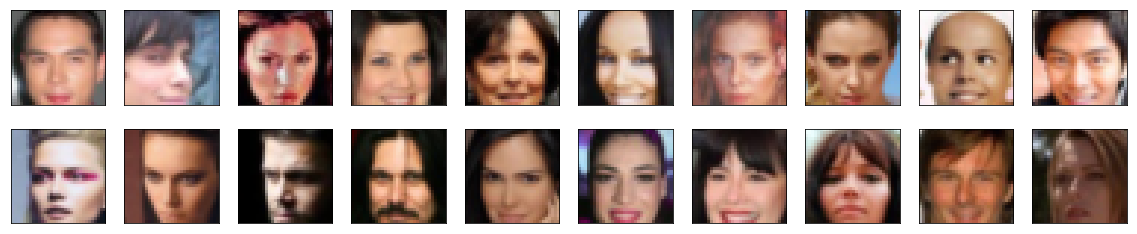

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    low, high = feature_range
    x = x * (high-low) + low
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = nn.Conv2d(3, conv_dim, 4, 2, bias=False)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, 2, bias=False)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, 4, 2, bias=False)
        
        self.fc = nn.Linear(conv_dim*4*2*2, 1)
        
        self.b_norm1 = nn.BatchNorm2d(conv_dim)
        self.b_norm2 = nn.BatchNorm2d(conv_dim*2)
        self.b_norm3 = nn.BatchNorm2d(conv_dim*4)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.b_norm1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.b_norm2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.b_norm3(self.conv3(x)), 0.2)
        x = x.view(-1, self.conv_dim*4*2*2)
        x = self.fc(x)
        x = F.tanh(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*8*3*3)
        
        self.deconv1 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, 3, 2, 1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 3, 2, 1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 3, 2, 1, bias=False)
        self.deconv4 = nn.ConvTranspose2d(conv_dim, 3, 3, 2, 2, output_padding=1, bias=False)
        
        self.b_norm1 = nn.BatchNorm2d(conv_dim*4)
        self.b_norm2 = nn.BatchNorm2d(conv_dim*2)
        self.b_norm3 = nn.BatchNorm2d(conv_dim)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 3, 3)
        x = F.leaky_relu(self.b_norm1(self.deconv1(x)), 0.2)
        x = F.leaky_relu(self.b_norm2(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.b_norm3(self.deconv3(x)), 0.2)
        x = torch.tanh(self.deconv4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if classname == 'Conv2d' or type(m) == 'Linear' or classname == 'ConvTranspose2d':
        nn.init.normal_(m.weight, mean=0, std=0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 64
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (b_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Generator(
  (fc): Linear(in_features=128, out_features=4608, bias=True)
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv4): ConvTranspose2d(64, 3, kernel_siz

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
       
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()   
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

lr = 0.0001
beta1 = 0.4
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2]) 
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
                        
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_real = D(real_images)
            d_real_loss = real_loss(d_real, smooth=True)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            d_loss = d_real_loss + d_fake_loss
            
            #if g_loss.item() - d_loss.item() < 0.15:
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss

            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            g_fake = D(fake_images)
            g_loss = real_loss(g_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.3938 | g_loss: 0.6989
Epoch [    1/   30] | d_loss: 1.2442 | g_loss: 0.6474
Epoch [    1/   30] | d_loss: 1.0339 | g_loss: 0.8775
Epoch [    1/   30] | d_loss: 0.9542 | g_loss: 0.9799
Epoch [    1/   30] | d_loss: 0.8748 | g_loss: 1.0734
Epoch [    1/   30] | d_loss: 0.8840 | g_loss: 1.0823
Epoch [    1/   30] | d_loss: 0.8286 | g_loss: 1.1642
Epoch [    1/   30] | d_loss: 0.8286 | g_loss: 1.1792
Epoch [    1/   30] | d_loss: 0.8079 | g_loss: 1.1984
Epoch [    1/   30] | d_loss: 0.8157 | g_loss: 1.2059
Epoch [    1/   30] | d_loss: 0.7756 | g_loss: 1.2243
Epoch [    1/   30] | d_loss: 0.7692 | g_loss: 1.2335
Epoch [    1/   30] | d_loss: 0.7976 | g_loss: 1.2447
Epoch [    1/   30] | d_loss: 0.7628 | g_loss: 1.2545
Epoch [    1/   30] | d_loss: 0.7807 | g_loss: 1.2290
Epoch [    1/   30] | d_loss: 0.7573 | g_loss: 1.2638
Epoch [    1/   30] | d_loss: 0.7464 | g_loss: 1.2766
Epoch [    1/   30] | d_loss: 0.7575 | g_loss: 1.2787
Epoch [    1/   30] | d_loss

Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3132
Epoch [    2/   30] | d_loss: 0.7268 | g_loss: 1.3124
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3132
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3132
Epoch [    2/   30] | d_loss: 0.7266 | g_loss: 1.3132
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7266 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7266 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7266 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7266 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7266 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss: 0.7265 | g_loss: 1.3133
Epoch [    2/   30] | d_loss

Epoch [    4/   30] | d_loss: 1.3629 | g_loss: 0.7953
Epoch [    4/   30] | d_loss: 1.3920 | g_loss: 0.8315
Epoch [    4/   30] | d_loss: 1.3580 | g_loss: 0.8198
Epoch [    4/   30] | d_loss: 1.3960 | g_loss: 0.8089
Epoch [    4/   30] | d_loss: 1.3620 | g_loss: 0.8179
Epoch [    4/   30] | d_loss: 1.3616 | g_loss: 0.8170
Epoch [    4/   30] | d_loss: 1.3383 | g_loss: 0.7915
Epoch [    4/   30] | d_loss: 1.3837 | g_loss: 0.8167
Epoch [    4/   30] | d_loss: 1.3463 | g_loss: 0.8030
Epoch [    4/   30] | d_loss: 1.3550 | g_loss: 0.8190
Epoch [    4/   30] | d_loss: 1.3562 | g_loss: 0.8300
Epoch [    4/   30] | d_loss: 1.4043 | g_loss: 0.8215
Epoch [    4/   30] | d_loss: 1.3977 | g_loss: 0.8260
Epoch [    4/   30] | d_loss: 1.3827 | g_loss: 0.8348
Epoch [    4/   30] | d_loss: 1.3896 | g_loss: 0.8534
Epoch [    4/   30] | d_loss: 1.3879 | g_loss: 0.8141
Epoch [    4/   30] | d_loss: 1.3581 | g_loss: 0.8081
Epoch [    4/   30] | d_loss: 1.3601 | g_loss: 0.8063
Epoch [    4/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.3563 | g_loss: 0.8063
Epoch [    6/   30] | d_loss: 1.3588 | g_loss: 0.8114
Epoch [    6/   30] | d_loss: 1.3781 | g_loss: 0.7903
Epoch [    6/   30] | d_loss: 1.3751 | g_loss: 0.7830
Epoch [    6/   30] | d_loss: 1.3646 | g_loss: 0.8108
Epoch [    6/   30] | d_loss: 1.3662 | g_loss: 0.8008
Epoch [    6/   30] | d_loss: 1.3801 | g_loss: 0.8061
Epoch [    6/   30] | d_loss: 1.3728 | g_loss: 0.8151
Epoch [    6/   30] | d_loss: 1.3915 | g_loss: 0.7876
Epoch [    6/   30] | d_loss: 1.3349 | g_loss: 0.8069
Epoch [    6/   30] | d_loss: 1.3615 | g_loss: 0.8099
Epoch [    6/   30] | d_loss: 1.3890 | g_loss: 0.8041
Epoch [    6/   30] | d_loss: 1.3889 | g_loss: 0.8077
Epoch [    6/   30] | d_loss: 1.3225 | g_loss: 0.7880
Epoch [    6/   30] | d_loss: 1.3725 | g_loss: 0.8043
Epoch [    6/   30] | d_loss: 1.3658 | g_loss: 0.7978
Epoch [    6/   30] | d_loss: 1.3481 | g_loss: 0.8114
Epoch [    6/   30] | d_loss: 1.3752 | g_loss: 0.8343
Epoch [    6/   30] | d_loss

Epoch [    7/   30] | d_loss: 1.3635 | g_loss: 0.7839
Epoch [    7/   30] | d_loss: 1.3571 | g_loss: 0.7726
Epoch [    7/   30] | d_loss: 1.3496 | g_loss: 0.8032
Epoch [    7/   30] | d_loss: 1.3696 | g_loss: 0.8100
Epoch [    7/   30] | d_loss: 1.3689 | g_loss: 0.7743
Epoch [    7/   30] | d_loss: 1.3779 | g_loss: 0.8431
Epoch [    7/   30] | d_loss: 1.3347 | g_loss: 0.7858
Epoch [    7/   30] | d_loss: 1.3611 | g_loss: 0.8223
Epoch [    7/   30] | d_loss: 1.3637 | g_loss: 0.8131
Epoch [    7/   30] | d_loss: 1.3723 | g_loss: 0.8207
Epoch [    7/   30] | d_loss: 1.3418 | g_loss: 0.7809
Epoch [    7/   30] | d_loss: 1.4314 | g_loss: 0.8313
Epoch [    7/   30] | d_loss: 1.3665 | g_loss: 0.8061
Epoch [    7/   30] | d_loss: 1.3752 | g_loss: 0.7886
Epoch [    7/   30] | d_loss: 1.3681 | g_loss: 0.8107
Epoch [    7/   30] | d_loss: 1.3617 | g_loss: 0.7789
Epoch [    7/   30] | d_loss: 1.3893 | g_loss: 0.8065
Epoch [    7/   30] | d_loss: 1.3593 | g_loss: 0.8456
Epoch [    7/   30] | d_loss

Epoch [    9/   30] | d_loss: 1.4148 | g_loss: 0.8340
Epoch [    9/   30] | d_loss: 1.3453 | g_loss: 0.8337
Epoch [    9/   30] | d_loss: 1.3564 | g_loss: 0.8020
Epoch [    9/   30] | d_loss: 1.3947 | g_loss: 0.8449
Epoch [    9/   30] | d_loss: 1.3689 | g_loss: 0.7890
Epoch [    9/   30] | d_loss: 1.3316 | g_loss: 0.8232
Epoch [    9/   30] | d_loss: 1.4174 | g_loss: 0.8743
Epoch [    9/   30] | d_loss: 1.3866 | g_loss: 0.8246
Epoch [    9/   30] | d_loss: 1.2899 | g_loss: 0.8478
Epoch [    9/   30] | d_loss: 1.3340 | g_loss: 0.8028
Epoch [    9/   30] | d_loss: 1.3465 | g_loss: 0.8000
Epoch [    9/   30] | d_loss: 1.3551 | g_loss: 0.8213
Epoch [    9/   30] | d_loss: 1.3513 | g_loss: 0.7915
Epoch [    9/   30] | d_loss: 1.2917 | g_loss: 0.8357
Epoch [    9/   30] | d_loss: 1.2889 | g_loss: 0.8096
Epoch [    9/   30] | d_loss: 1.3732 | g_loss: 0.8457
Epoch [    9/   30] | d_loss: 1.3313 | g_loss: 0.8253
Epoch [    9/   30] | d_loss: 1.3684 | g_loss: 0.8076
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 1.3667 | g_loss: 0.8174
Epoch [   11/   30] | d_loss: 1.3764 | g_loss: 0.7888
Epoch [   11/   30] | d_loss: 1.3698 | g_loss: 0.8376
Epoch [   11/   30] | d_loss: 1.3309 | g_loss: 0.8065
Epoch [   11/   30] | d_loss: 1.3147 | g_loss: 0.8274
Epoch [   11/   30] | d_loss: 1.3594 | g_loss: 0.8250
Epoch [   11/   30] | d_loss: 1.3560 | g_loss: 0.8261
Epoch [   11/   30] | d_loss: 1.3234 | g_loss: 0.8562
Epoch [   11/   30] | d_loss: 1.3374 | g_loss: 0.8433
Epoch [   11/   30] | d_loss: 1.3567 | g_loss: 0.8319
Epoch [   11/   30] | d_loss: 1.4282 | g_loss: 0.8466
Epoch [   11/   30] | d_loss: 1.3299 | g_loss: 0.8474
Epoch [   11/   30] | d_loss: 1.3327 | g_loss: 0.7965
Epoch [   11/   30] | d_loss: 1.4046 | g_loss: 0.7609
Epoch [   11/   30] | d_loss: 1.3590 | g_loss: 0.8389
Epoch [   11/   30] | d_loss: 1.3036 | g_loss: 0.8461
Epoch [   11/   30] | d_loss: 1.3392 | g_loss: 0.8367
Epoch [   11/   30] | d_loss: 1.3190 | g_loss: 0.8324
Epoch [   11/   30] | d_loss

Epoch [   12/   30] | d_loss: 1.4189 | g_loss: 0.8729
Epoch [   12/   30] | d_loss: 1.3856 | g_loss: 0.7608
Epoch [   12/   30] | d_loss: 1.2556 | g_loss: 0.7942
Epoch [   12/   30] | d_loss: 1.3473 | g_loss: 0.9125
Epoch [   12/   30] | d_loss: 1.4553 | g_loss: 0.8170
Epoch [   12/   30] | d_loss: 1.2869 | g_loss: 0.8315
Epoch [   12/   30] | d_loss: 1.3452 | g_loss: 0.8210
Epoch [   12/   30] | d_loss: 1.4746 | g_loss: 0.8449
Epoch [   12/   30] | d_loss: 1.3698 | g_loss: 0.7993
Epoch [   12/   30] | d_loss: 1.3433 | g_loss: 0.8712
Epoch [   12/   30] | d_loss: 1.3426 | g_loss: 0.7930
Epoch [   12/   30] | d_loss: 1.2701 | g_loss: 0.8210
Epoch [   12/   30] | d_loss: 1.3795 | g_loss: 0.8097
Epoch [   12/   30] | d_loss: 1.3598 | g_loss: 0.7544
Epoch [   12/   30] | d_loss: 1.3597 | g_loss: 0.8921
Epoch [   12/   30] | d_loss: 1.3201 | g_loss: 0.7961
Epoch [   13/   30] | d_loss: 1.3613 | g_loss: 0.7946
Epoch [   13/   30] | d_loss: 1.3442 | g_loss: 0.8888
Epoch [   13/   30] | d_loss

Epoch [   14/   30] | d_loss: 1.3708 | g_loss: 0.8620
Epoch [   14/   30] | d_loss: 1.3724 | g_loss: 0.8180
Epoch [   14/   30] | d_loss: 1.3278 | g_loss: 0.8017
Epoch [   14/   30] | d_loss: 1.4015 | g_loss: 0.9334
Epoch [   14/   30] | d_loss: 1.3110 | g_loss: 0.8189
Epoch [   14/   30] | d_loss: 1.3675 | g_loss: 0.8192
Epoch [   14/   30] | d_loss: 1.3131 | g_loss: 0.8931
Epoch [   14/   30] | d_loss: 1.4229 | g_loss: 0.8947
Epoch [   14/   30] | d_loss: 1.3843 | g_loss: 0.7430
Epoch [   14/   30] | d_loss: 1.4429 | g_loss: 0.8174
Epoch [   14/   30] | d_loss: 1.3392 | g_loss: 0.8080
Epoch [   14/   30] | d_loss: 1.2872 | g_loss: 0.7911
Epoch [   14/   30] | d_loss: 1.4449 | g_loss: 0.9144
Epoch [   14/   30] | d_loss: 1.3299 | g_loss: 0.8544
Epoch [   14/   30] | d_loss: 1.2890 | g_loss: 0.9058
Epoch [   14/   30] | d_loss: 1.3232 | g_loss: 0.7749
Epoch [   14/   30] | d_loss: 1.2436 | g_loss: 0.8322
Epoch [   14/   30] | d_loss: 1.3449 | g_loss: 0.8014
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 1.3662 | g_loss: 0.8452
Epoch [   16/   30] | d_loss: 1.4750 | g_loss: 0.7759
Epoch [   16/   30] | d_loss: 1.3496 | g_loss: 0.8137
Epoch [   16/   30] | d_loss: 1.3891 | g_loss: 0.9211
Epoch [   16/   30] | d_loss: 1.2868 | g_loss: 0.8896
Epoch [   16/   30] | d_loss: 1.3911 | g_loss: 0.8203
Epoch [   16/   30] | d_loss: 1.2385 | g_loss: 0.8324
Epoch [   16/   30] | d_loss: 1.3435 | g_loss: 0.8620
Epoch [   16/   30] | d_loss: 1.3822 | g_loss: 0.7879
Epoch [   16/   30] | d_loss: 1.3809 | g_loss: 0.8834
Epoch [   16/   30] | d_loss: 1.3073 | g_loss: 0.7571
Epoch [   16/   30] | d_loss: 1.4185 | g_loss: 0.9387
Epoch [   16/   30] | d_loss: 1.3222 | g_loss: 0.9091
Epoch [   16/   30] | d_loss: 1.3582 | g_loss: 0.7977
Epoch [   16/   30] | d_loss: 1.2889 | g_loss: 0.8803
Epoch [   16/   30] | d_loss: 1.3207 | g_loss: 0.8617
Epoch [   16/   30] | d_loss: 1.4845 | g_loss: 0.9789
Epoch [   16/   30] | d_loss: 1.3240 | g_loss: 0.8520
Epoch [   16/   30] | d_loss

Epoch [   17/   30] | d_loss: 1.2413 | g_loss: 0.9460
Epoch [   17/   30] | d_loss: 1.3581 | g_loss: 0.8267
Epoch [   17/   30] | d_loss: 1.4160 | g_loss: 0.8526
Epoch [   17/   30] | d_loss: 1.2863 | g_loss: 0.8495
Epoch [   17/   30] | d_loss: 1.2903 | g_loss: 0.8375
Epoch [   17/   30] | d_loss: 1.4014 | g_loss: 0.7995
Epoch [   17/   30] | d_loss: 1.2772 | g_loss: 0.8720
Epoch [   17/   30] | d_loss: 1.3700 | g_loss: 0.8589
Epoch [   17/   30] | d_loss: 1.3332 | g_loss: 0.8086
Epoch [   17/   30] | d_loss: 1.3404 | g_loss: 0.9433
Epoch [   18/   30] | d_loss: 1.2458 | g_loss: 0.9217
Epoch [   18/   30] | d_loss: 1.3079 | g_loss: 0.8596
Epoch [   18/   30] | d_loss: 1.4531 | g_loss: 0.8369
Epoch [   18/   30] | d_loss: 1.3088 | g_loss: 0.7475
Epoch [   18/   30] | d_loss: 1.1390 | g_loss: 0.7421
Epoch [   18/   30] | d_loss: 1.3265 | g_loss: 0.9189
Epoch [   18/   30] | d_loss: 1.4036 | g_loss: 0.8623
Epoch [   18/   30] | d_loss: 1.3945 | g_loss: 0.9562
Epoch [   18/   30] | d_loss

Epoch [   19/   30] | d_loss: 1.3084 | g_loss: 0.8555
Epoch [   19/   30] | d_loss: 1.3019 | g_loss: 0.9298
Epoch [   19/   30] | d_loss: 1.2928 | g_loss: 0.8402
Epoch [   19/   30] | d_loss: 1.3023 | g_loss: 0.7919
Epoch [   19/   30] | d_loss: 1.3035 | g_loss: 0.7998
Epoch [   19/   30] | d_loss: 1.2933 | g_loss: 0.8241
Epoch [   19/   30] | d_loss: 1.3533 | g_loss: 0.9790
Epoch [   19/   30] | d_loss: 1.2587 | g_loss: 0.7864
Epoch [   19/   30] | d_loss: 1.3062 | g_loss: 0.8688
Epoch [   19/   30] | d_loss: 1.3022 | g_loss: 0.9401
Epoch [   19/   30] | d_loss: 1.3922 | g_loss: 0.6560
Epoch [   19/   30] | d_loss: 1.3260 | g_loss: 0.8176
Epoch [   19/   30] | d_loss: 1.3570 | g_loss: 0.8422
Epoch [   19/   30] | d_loss: 1.1834 | g_loss: 0.7835
Epoch [   19/   30] | d_loss: 1.5214 | g_loss: 0.9628
Epoch [   19/   30] | d_loss: 1.3807 | g_loss: 0.7740
Epoch [   19/   30] | d_loss: 1.2516 | g_loss: 0.9364
Epoch [   19/   30] | d_loss: 1.2642 | g_loss: 0.8236
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 1.2103 | g_loss: 0.9219
Epoch [   21/   30] | d_loss: 1.3842 | g_loss: 0.8983
Epoch [   21/   30] | d_loss: 1.3244 | g_loss: 0.8336
Epoch [   21/   30] | d_loss: 1.2615 | g_loss: 0.8417
Epoch [   21/   30] | d_loss: 1.2652 | g_loss: 0.7460
Epoch [   21/   30] | d_loss: 1.3485 | g_loss: 0.8539
Epoch [   21/   30] | d_loss: 1.3305 | g_loss: 0.8319
Epoch [   21/   30] | d_loss: 1.3289 | g_loss: 0.8111
Epoch [   21/   30] | d_loss: 1.3771 | g_loss: 0.9736
Epoch [   21/   30] | d_loss: 1.3785 | g_loss: 0.8843
Epoch [   21/   30] | d_loss: 1.4111 | g_loss: 0.8435
Epoch [   21/   30] | d_loss: 1.3928 | g_loss: 0.8973
Epoch [   21/   30] | d_loss: 1.3378 | g_loss: 0.8094
Epoch [   21/   30] | d_loss: 1.3792 | g_loss: 0.9194
Epoch [   21/   30] | d_loss: 1.4279 | g_loss: 0.8818
Epoch [   21/   30] | d_loss: 1.3680 | g_loss: 0.9081
Epoch [   21/   30] | d_loss: 1.2783 | g_loss: 0.9164
Epoch [   21/   30] | d_loss: 1.1964 | g_loss: 1.0039
Epoch [   21/   30] | d_loss

Epoch [   22/   30] | d_loss: 1.2216 | g_loss: 0.8439
Epoch [   22/   30] | d_loss: 1.4568 | g_loss: 0.8596
Epoch [   22/   30] | d_loss: 1.3691 | g_loss: 0.8239
Epoch [   22/   30] | d_loss: 1.2811 | g_loss: 0.9382
Epoch [   23/   30] | d_loss: 1.3101 | g_loss: 0.9149
Epoch [   23/   30] | d_loss: 1.2405 | g_loss: 0.8660
Epoch [   23/   30] | d_loss: 1.3211 | g_loss: 0.7572
Epoch [   23/   30] | d_loss: 1.1988 | g_loss: 0.9749
Epoch [   23/   30] | d_loss: 1.3551 | g_loss: 0.8958
Epoch [   23/   30] | d_loss: 1.2217 | g_loss: 0.9173
Epoch [   23/   30] | d_loss: 1.2217 | g_loss: 0.8921
Epoch [   23/   30] | d_loss: 1.2725 | g_loss: 0.9986
Epoch [   23/   30] | d_loss: 1.2741 | g_loss: 0.9486
Epoch [   23/   30] | d_loss: 1.2772 | g_loss: 0.8323
Epoch [   23/   30] | d_loss: 1.3026 | g_loss: 0.8030
Epoch [   23/   30] | d_loss: 1.1486 | g_loss: 0.8585
Epoch [   23/   30] | d_loss: 1.3942 | g_loss: 0.9261
Epoch [   23/   30] | d_loss: 1.3613 | g_loss: 0.8573
Epoch [   23/   30] | d_loss

Epoch [   24/   30] | d_loss: 1.3083 | g_loss: 0.9379
Epoch [   24/   30] | d_loss: 1.3677 | g_loss: 1.0499
Epoch [   24/   30] | d_loss: 1.0722 | g_loss: 0.7998
Epoch [   24/   30] | d_loss: 1.5006 | g_loss: 1.0002
Epoch [   24/   30] | d_loss: 1.2304 | g_loss: 0.9603
Epoch [   24/   30] | d_loss: 1.2586 | g_loss: 0.8502
Epoch [   24/   30] | d_loss: 1.2570 | g_loss: 0.9911
Epoch [   24/   30] | d_loss: 1.3236 | g_loss: 0.8784
Epoch [   24/   30] | d_loss: 1.2715 | g_loss: 0.7797
Epoch [   24/   30] | d_loss: 1.3598 | g_loss: 0.8472
Epoch [   24/   30] | d_loss: 1.3472 | g_loss: 0.7691
Epoch [   24/   30] | d_loss: 1.3448 | g_loss: 0.9357
Epoch [   24/   30] | d_loss: 1.1791 | g_loss: 0.8200
Epoch [   24/   30] | d_loss: 1.0950 | g_loss: 1.0864
Epoch [   24/   30] | d_loss: 1.3222 | g_loss: 0.8036
Epoch [   24/   30] | d_loss: 1.3420 | g_loss: 0.9098
Epoch [   24/   30] | d_loss: 1.2374 | g_loss: 0.8417
Epoch [   24/   30] | d_loss: 1.4607 | g_loss: 0.8907
Epoch [   24/   30] | d_loss

Epoch [   26/   30] | d_loss: 1.4910 | g_loss: 1.1855
Epoch [   26/   30] | d_loss: 1.2324 | g_loss: 0.9478
Epoch [   26/   30] | d_loss: 1.4730 | g_loss: 0.9570
Epoch [   26/   30] | d_loss: 1.2869 | g_loss: 0.8913
Epoch [   26/   30] | d_loss: 1.3298 | g_loss: 0.9056
Epoch [   26/   30] | d_loss: 1.2448 | g_loss: 0.9061
Epoch [   26/   30] | d_loss: 1.3596 | g_loss: 0.9431
Epoch [   26/   30] | d_loss: 1.1184 | g_loss: 1.0545
Epoch [   26/   30] | d_loss: 1.1495 | g_loss: 0.8686
Epoch [   26/   30] | d_loss: 1.3108 | g_loss: 0.8678
Epoch [   26/   30] | d_loss: 1.3521 | g_loss: 0.8487
Epoch [   26/   30] | d_loss: 1.4160 | g_loss: 0.8580
Epoch [   26/   30] | d_loss: 1.4255 | g_loss: 0.8129
Epoch [   26/   30] | d_loss: 1.3241 | g_loss: 0.9747
Epoch [   26/   30] | d_loss: 1.2310 | g_loss: 0.8717
Epoch [   26/   30] | d_loss: 1.1650 | g_loss: 1.0028
Epoch [   26/   30] | d_loss: 1.3169 | g_loss: 0.9646
Epoch [   26/   30] | d_loss: 1.3579 | g_loss: 0.9759
Epoch [   26/   30] | d_loss

Epoch [   28/   30] | d_loss: 1.2503 | g_loss: 0.9014
Epoch [   28/   30] | d_loss: 1.2472 | g_loss: 0.9322
Epoch [   28/   30] | d_loss: 1.3762 | g_loss: 0.9099
Epoch [   28/   30] | d_loss: 1.3124 | g_loss: 0.9346
Epoch [   28/   30] | d_loss: 1.3981 | g_loss: 0.8880
Epoch [   28/   30] | d_loss: 1.3220 | g_loss: 1.0199
Epoch [   28/   30] | d_loss: 1.2441 | g_loss: 0.9489
Epoch [   28/   30] | d_loss: 1.3278 | g_loss: 0.9822
Epoch [   28/   30] | d_loss: 1.2539 | g_loss: 0.9304
Epoch [   28/   30] | d_loss: 1.3244 | g_loss: 0.9665
Epoch [   28/   30] | d_loss: 1.3244 | g_loss: 0.7047
Epoch [   28/   30] | d_loss: 1.1670 | g_loss: 0.9177
Epoch [   28/   30] | d_loss: 1.3207 | g_loss: 0.9405
Epoch [   28/   30] | d_loss: 1.4250 | g_loss: 1.0218
Epoch [   28/   30] | d_loss: 1.1354 | g_loss: 0.9180
Epoch [   28/   30] | d_loss: 1.2384 | g_loss: 1.0197
Epoch [   28/   30] | d_loss: 1.3598 | g_loss: 0.9174
Epoch [   28/   30] | d_loss: 1.4054 | g_loss: 0.9031
Epoch [   28/   30] | d_loss

Epoch [   29/   30] | d_loss: 1.2236 | g_loss: 0.9532
Epoch [   29/   30] | d_loss: 1.1083 | g_loss: 0.9402
Epoch [   29/   30] | d_loss: 1.5215 | g_loss: 1.0299
Epoch [   29/   30] | d_loss: 1.0200 | g_loss: 1.1590
Epoch [   29/   30] | d_loss: 1.1537 | g_loss: 1.0595
Epoch [   29/   30] | d_loss: 1.2369 | g_loss: 0.8841
Epoch [   29/   30] | d_loss: 1.3443 | g_loss: 0.9452
Epoch [   29/   30] | d_loss: 1.2268 | g_loss: 0.9171
Epoch [   29/   30] | d_loss: 1.4336 | g_loss: 1.0928
Epoch [   29/   30] | d_loss: 1.2800 | g_loss: 0.9854
Epoch [   29/   30] | d_loss: 1.2298 | g_loss: 0.9481
Epoch [   29/   30] | d_loss: 1.2590 | g_loss: 0.9767
Epoch [   29/   30] | d_loss: 1.2163 | g_loss: 1.0618
Epoch [   29/   30] | d_loss: 1.1132 | g_loss: 0.9494
Epoch [   29/   30] | d_loss: 1.3374 | g_loss: 0.8261
Epoch [   29/   30] | d_loss: 1.1890 | g_loss: 0.9413
Epoch [   29/   30] | d_loss: 1.3659 | g_loss: 0.8615
Epoch [   29/   30] | d_loss: 1.2323 | g_loss: 0.9924
Epoch [   29/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

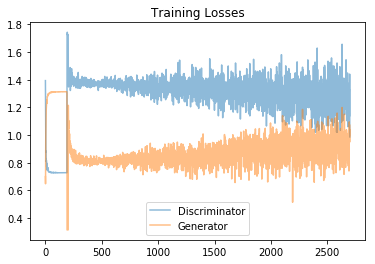

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

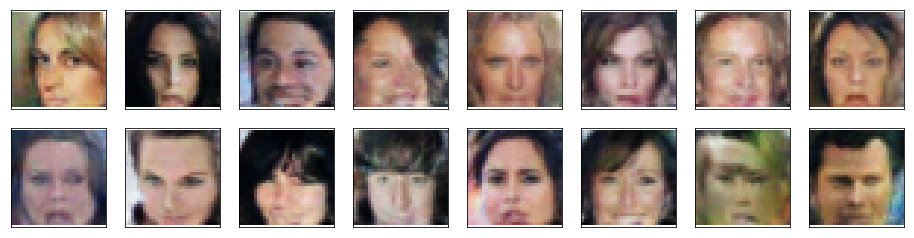

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** All of the generated white faces are fairly convincing.  The twor or so that might not be white don't look very good.  To fix this, you could include more people of color in the dataset or use some kind of transform to darken skin color to selected tones.  This would take some time or trial and error.  Or maybe just training for much longer would work.

A larger model size would help, but I think training for longer would help too.  To be honest, the thing that would most help this GAN is increasing the number of pixels to make the faces easier to see and give the model more data to work with.  It would increase the training time a lot and might call for greater complexity in the architecture, but it would make it much easier to see how well the model was adapting to the data.

As far as optimization strategy goes, I think that 30 epochs was enough to produce convincing faces.  It appears as though the two were converging in the middle, and probably could have done so in about 10 or 20 more epochs.  I believe a convergence of this kind would be a Nash euilibrium, correct?  This is not certain, however.  After looking up some information on GANs, I think using the BEGAN, which uses local sampling techniques for optimaztion.  Not sure how it works or how to implement that, but the general idea made a lot sense when I read about it.  

All things considered, I think this model performed pretty well for what it is.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.